<a href="https://colab.research.google.com/github/Pumafi/problem_solving_rl_pumafi/blob/main/initial_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARC-AGI

Ferdinand Bhavsar

PhD student, Mines Paris

In [1]:
RUNNING_IN_COLAB = True

%cd /content

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/Pumafi/problem_solving_rl_pumafi'
    BRANCH   = 'main'
    REPO_DIR = 'problem_solving_rl_pumafi'

    from pathlib import Path

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}

    %cd {REPO_DIR}

/content
Cloning into 'problem_solving_rl_pumafi'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 389.89 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/problem_solving_rl_pumafi


### Imports

In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np

import random
import math
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib import colors


from scipy.stats import kde
from sklearn.metrics.pairwise import euclidean_distances

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [3]:
# Load code from the repo
from utils.data_handling import get_color_map, pad_to_shape, preprocess_challenge_data

### Utilities

Get color map (took from some random code I had lying around, so the colors are not the ones from ARC-AGI

### Dataset Loading

In [4]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

training_challenges = load_json('./data/arc-agi_training_challenges.json')
training_solutions = load_json('./data/arc-agi_training_solutions.json')
evaluation_challenges = load_json('./data/arc-agi_evaluation_challenges.json')

print("Data loaded successfully.")
print(f"Training tasks: {len(training_challenges)}")
print(f"Evaluation tasks: {len(evaluation_challenges)}")

Data loaded successfully.
Training tasks: 400
Evaluation tasks: 400


Preprocess the challenge data (I'm not touching the indentation, it was a nightmare of using jupyter AND colab for some tests)

In [5]:
challenge_propositioner_inputs, train_solver_inputs, train_solver_outputs, test_solver_inputs, test_solver_outputs = preprocess_challenge_data(training_challenges, training_solutions)
print(len(challenge_propositioner_inputs), len(train_solver_inputs), len(train_solver_outputs), len(test_solver_inputs), len(test_solver_outputs))

400 400 400 400 400


In [6]:
# visualize data types
print(type(challenge_propositioner_inputs))
print(type(challenge_propositioner_inputs[0]))
print(type(challenge_propositioner_inputs[0][0]))
print(type(challenge_propositioner_inputs[0][0][0]))

<class 'list'>
<class 'list'>
<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
# In order of access we have:
#     challenge_propositioner_inputs [problem_nb (list)] [example_nb (list)] [0/1 - input/output (tuple)] -> [30, 30, 10] (ndarray)

# Visualize the size of examples sets (NB: All have at least 2 examples, but 2 is to few for my idea)
for i in range(5):
  print("Problem nb ", i +1, " | nb examples: ", len(challenge_propositioner_inputs[i]))

print("\nSize of one grid: ", challenge_propositioner_inputs[0][0][0].shape)

Problem nb  1  | nb examples:  5
Problem nb  2  | nb examples:  5
Problem nb  3  | nb examples:  3
Problem nb  4  | nb examples:  2
Problem nb  5  | nb examples:  3

Size of one grid:  (30, 30, 10)


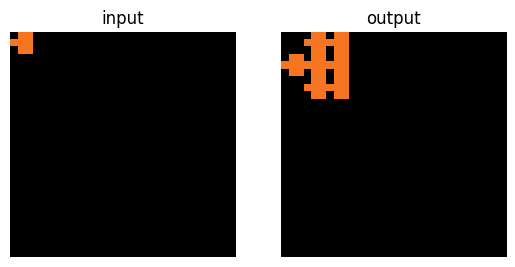

In [36]:
cmap, norm = get_color_map(number_of_categories=9)

plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('output')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.show()

In [8]:
# Idea: create sub-array of fixed sized with success/fail examples
# 1) create a fail function that creates failes examples (random noise & rotation & color translation& random selection)
# 2) Remove the challenges with only two examples (we want at least 2 success)
# 3) Split challenges with more than 6 examples (6 into 3/3, 7 into 4/3, 8 into 4/4, 9 into 5/4, 10 into 4/3/3)
# 4) Isolate for each task 2 successes
# 5) The rest has to be completed with failure

In [57]:
import numpy as np
import tensorflow as tf

g = tf.random.get_global_generator()


def cosine_schedule_function(t, max_t=1., epsilon=1e-3):
    t = tf.cast(t, tf.float32)
    f_t = tf.math.cos(((t / max_t) + epsilon) / (1 + epsilon) * (np.pi / 2)) ** 2
    f_0 = tf.math.cos(((t * 0 / max_t) + epsilon) / (1 + epsilon) * (np.pi / 2)) ** 2
    return f_t / f_0


def make_qmatrix_integral(nb_categories, t, tm1=None):
    Q_integral = tf.zeros((nb_categories, nb_categories), dtype=tf.float32)

    if tm1 is None:
        tm1 = tf.zeros_like(t, dtype=tf.float32)

    for i in range(nb_categories):
        for j in range(nb_categories):
            if i != j:
                Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, j]]),
                                                         updates=[-1 / (nb_categories - 1) * tf.squeeze(
                                                             tf.math.log(cosine_schedule_function(t, max_t=1.)))
                                                                  + 1 / (nb_categories - 1) * tf.squeeze(
                                                             tf.math.log(cosine_schedule_function(tm1, max_t=1.)))])

    for i in range(nb_categories):
        Q_integral = tf.tensor_scatter_nd_update(Q_integral, indices=tf.constant([[i, i]]),
                                                 updates=[-tf.reduce_sum(Q_integral[i])])

    return Q_integral


def probability_function(nb_categories, t, step_size):
    """
    Compute the categorical forward probability from t to t + step_size

    """
    t = tf.cast(t, dtype=tf.float32)
    if step_size == 0.:
        tm1 = None
    else:
        tm1 = tf.cast(t - step_size, dtype=tf.float32)
    Q = make_qmatrix_integral(nb_categories, t, tm1)

    return Q


@tf.function
def forward_process(x0, step, nb_categories):
    if len(x0.shape) != 3:
        raise Exception("Entry must have 3 dims but {0} were found".format(len(x0.shape)))

    t = tf.squeeze(step)
    Q = tf.linalg.expm(make_qmatrix_integral(nb_categories, t))

    pxt = tf.tensordot(x0, Q, axes=[-1, 0])
    height, width, _ = pxt.shape
    flat_pxt = tf.reshape(pxt, (-1, nb_categories))
    cum_sum = tf.math.cumsum(flat_pxt, axis=-1)

    unif = tf.cast(g.uniform(shape=(len(cum_sum), 1)), dtype=tf.float32)
    random_values = tf.math.argmax((unif < cum_sum), axis=1)
    xt = tf.reshape(random_values, (height, width))
    xt = tf.cast(tf.one_hot(xt, nb_categories), dtype=tf.float32)

    return xt

In [61]:
import random

def noise_grid(grid):
  grid = forward_process(grid, 0.25, 10).numpy()
  return grid

def color_change_grid(grid):
    k = random.randint(1, 5)
    grid = np.roll(grid, k, -1)
    return grid

def flip_grid(grid):
    grid = np.flip(grid, axis=(0,1))
    return grid


def rotation(grid):
    k = random.randint(1, 3)
    grid = np.rot90(grid, k=k)
    return grid

In [69]:
show_failure_cases = False

if show_failure_cases:
    flipped_grid = flip_grid(challenge_propositioner_inputs[0][0][0])

    rotated_grid = rotation(challenge_propositioner_inputs[0][0][0])

    color_changed = color_change_grid(challenge_propositioner_inputs[0][0][0])

    noised_grid = noise_grid(challenge_propositioner_inputs[0][0][0])

    plt.title('og')
    plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

    plt.title('flipped')
    plt.imshow(np.argmax(flipped_grid, axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

    plt.title('rotated')
    plt.imshow(np.argmax(rotated_grid, axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

    plt.title('color changed')
    plt.imshow(np.argmax(color_changed, axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

    plt.title('noised grid')
    plt.imshow(np.argmax(noised_grid, axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

In [ ]:
def create_fail(challenge_grids):
  # check if diff than inpu